In [450]:
# %pip install qubovert
# %pip install qiskit
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install networkx

In [451]:
from qubovert import boolean_var, QUBO
import pandas as pd
from qubovert.sim import anneal_qubo
import numpy as np
import re
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicProvider
from qiskit.quantum_info import Statevector
from qiskit.circuit.quantumcircuit import QuantumCircuit as QCtype
from itertools import product
from qiskit import transpile
import numpy as np
import os
from qiskit.circuit.library import XGate, IGate, RZGate, SXGate, CXGate, U3Gate, ZGate, HGate, TGate, TdgGate, SGate, CCXGate, RXGate, Reset
# import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import networkx as nx


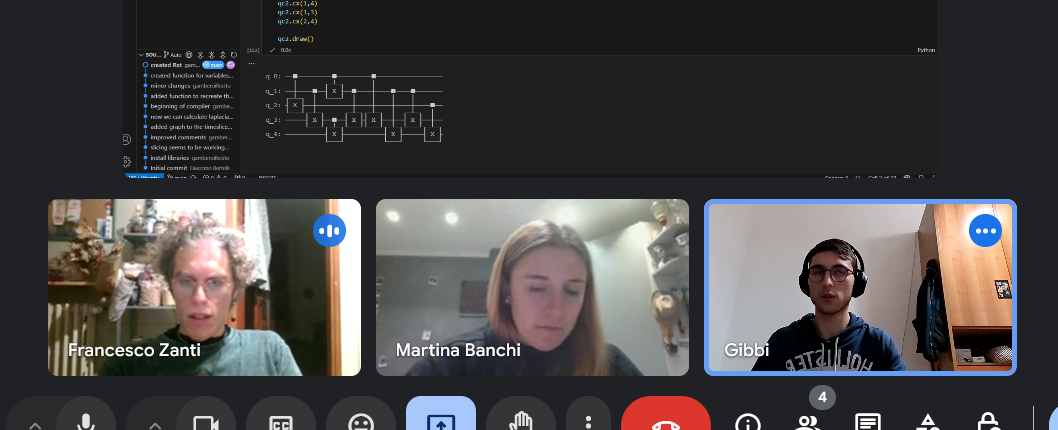

### Creating the quantum circuit to optimize

Quantum circuit (qc) with 5 qubits
and apply cnot gates as in Fig.2 of the paper

In [452]:
qc2 = QuantumCircuit(5)
qc2.cx(0,2)
# qc2.x(1)
qc2.cx(1,3)
qc2.cx(0,1)
qc2.cx(3,4)
qc2.cx(1,3)
qc2.cx(0,3)
qc2.cx(1,4)
qc2.cx(1,3)
qc2.cx(2,4)

qc2.draw()

q_0: ──■─────────■─────────■─────────────────
       │       ┌─┴─┐       │                 
q_1: ──┼────■──┤ X ├──■────┼────■────■───────
     ┌─┴─┐  │  └───┘  │    │    │    │       
q_2: ┤ X ├──┼─────────┼────┼────┼────┼────■──
     └───┘┌─┴─┐     ┌─┴─┐┌─┴─┐  │  ┌─┴─┐  │  
q_3: ─────┤ X ├──■──┤ X ├┤ X ├──┼──┤ X ├──┼──
          └───┘┌─┴─┐└───┘└───┘┌─┴─┐└───┘┌─┴─┐
q_4: ──────────┤ X ├──────────┤ X ├─────┤ X ├
               └───┘          └───┘     └───┘

### Gate class

The `Gate` class is used to store information about
the gates such as the name of the gate, the qiskit
function that implements it and the qubits it operates on

In [453]:
class Gate:
    convertions = {
        'cx': CXGate,
        'x': XGate
    }
    def __init__(self, name:str, qubits:list, params:list=None):
        self.name = name
        self.qubits = qubits
        self.params = params
        try:
            self.func = self.convertions[name]
        except KeyError:
            raise Exception("This gate is not supported") from None
            
    def __repr__(self):
        s = f"(Gate: name: {self.name}, qubits: {self.qubits}"
        if self.params:
            s += f", Params: {self.params}"

        s += ")"
        return s


def get_qubits_idxs(qubits:list)->list[int]:
    '''Given a list of qubits, it returns a list of their indexes''' 
    idxs = []
    for q in qubits:
        idxs.append(q._index)

    return idxs


### Iterating over gates in a qiskit ciruit

We can iterate over the gates in a circuit in this way

The problem is that the informations are not easy to use (see below)

In [454]:
for i in qc2.data:
    print(i)

CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'q'), 0), Qubit(QuantumRegister(5, 'q'), 2)), clbits=())
CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'q'), 1), Qubit(QuantumRegister(5, 'q'), 3)), clbits=())
CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'q'), 0), Qubit(QuantumRegister(5, 'q'), 1)), clbits=())
CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'q'), 3), Qubit(QuantumRegister(5, 'q'), 4)), clbits=())
CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'q'), 1), Qubit(QuantumRegister(5, 'q'), 3)), clbits=())
CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])

So we can use the class we defined before and the 
`get_qubits_idxs()` function to make them nicer to
work with

In [455]:

def get_gates_from_circuit(qc) -> list[Gate]:
    '''Given a QuantumCircuit, it returns a list of Gates'''
    gate_list = []
    # Iterate over all the gates in the qc
    for i in qc.data:
        op = i.operation.name
        qubits = i.qubits
        params = i.operation.params
        # Convert the qubits to a list of indexes
        qubits_indexes = get_qubits_idxs(qubits)

        # Add to the end of the gate_list the Gate
        gate_list.append(Gate(op, qubits_indexes, params))
    return gate_list

gate_list = get_gates_from_circuit(qc2)
for g in gate_list:
    print(g)
    

(Gate: name: cx, qubits: [0, 2])
(Gate: name: cx, qubits: [1, 3])
(Gate: name: cx, qubits: [0, 1])
(Gate: name: cx, qubits: [3, 4])
(Gate: name: cx, qubits: [1, 3])
(Gate: name: cx, qubits: [0, 3])
(Gate: name: cx, qubits: [1, 4])
(Gate: name: cx, qubits: [1, 3])
(Gate: name: cx, qubits: [2, 4])


### Time slices

Time slices are basically a list of gates but it is convenient to make a class
that represents a time slice so that we can use them more easily (for example with the function
`contains_any` we can see if any qubit in a list is already present in the time slice).

For each time slice we get also get the laplacian matrix of the graph.

In [456]:
# The TimeSlice class is a fancy list of gates
class TimeSlice:
    def __init__(self, idx, num_qubits=5):
        self.idx = idx
        self.num_qubits = num_qubits
        self.gates:list[Gate] = []
        # involved_qubits stores the qubits already involved in the slice
        # it is useful while performing slicing
        self.involved_qubits = []
        self._qubit_connections = [] # list of the connections between the qubits inside this time slice e.g. [(0,1), (3,4)]
        self.graph = nx.Graph() # graph of interaction of the qubits

    def append(self, gate:Gate):
        '''Adds the gate to the timeSlice making sure that the qubits are valid qubits'''
        # check if the gate we want to add to the slice
        # operates on the correct qubits
        for i in gate.qubits:
            if i >= self.num_qubits:
                raise(f"The TimeSlice has {self.num_qubits} but a gate acting on qubit {i} was added")
            if i in self.involved_qubits:
                raise(f"Error: qubit {i} is already present in TimeSlice{self.idx}")

            self.involved_qubits.append(i)
        
        # create the graph of the interactions of the qubits involved in the same gate
        for l in list(itertools.combinations(gate.qubits, 2)):
            self._qubit_connections.append(l) ## ATTENZIONE: nel paper non tutti i qubit coinvolti in un gate sono connessi tra di loro
        
        # add nodes (qubits) to the graph
        self.graph.add_nodes_from(gate.qubits)

        # add edges to the graph
        self.graph.add_edges_from(self._qubit_connections)
            
        self.gates.append(gate)

    @property
    def laplacian(self):
        '''Laplacian matrix of the graph
        taking into account also qubits that are not present in the slice
        (i.e. the ones that generate columns of all zeroes)'''

        G = nx.Graph()
        G.add_nodes_from(range(self.num_qubits))
        G.add_edges_from(self._qubit_connections)
        # fig, axs = plt.subplots(1, 1, figsize=(2 * 1, 2))
        # pos = nx.shell_layout(G, scale=0.4, rotate=0)  # Posizioni dei nodi
        # nx.draw(G, pos, ax=axs, with_labels=True, node_size=300, node_color='red', font_size=10, font_color='black')
        return nx.laplacian_matrix(G).todense()

    def contains_any(self, qubits: list):
        '''Returns true if at least one of the qubits is already used in the timeSlice'''
        return True if [i for i in qubits if i in self.involved_qubits] else False

    def show(self):
# Crea una figura con un numero di sottofigure adeguato
        fig, axs = plt.subplots(1, 1, figsize=(2 * 1, 2))
        pos = nx.shell_layout(self.graph, scale=0.4, rotate=0)  # Posizioni dei nodi
        nx.draw(self.graph, pos, ax=axs, with_labels=True, node_size=300, node_color='lightblue', font_size=10, font_color='black')
        print(self.laplacian)
    @property
    def quantum_circuit(self) -> QCtype:
        qc = QuantumCircuit(self.num_qubits)
        for gate in self.gates:
            qc.compose(gate.func(*gate.params), gate.qubits, inplace=True)
        return qc

    def __repr__(self):
        s = f"(TimeSlice{self.idx}, gates: {self.gates}, edges: {self._qubit_connections})"
        return s

### Slicing the circuit

We can now slice the circuit loosely following algorithm 1 of the paper

In [457]:

def slice_circuit(qc, num_qubits) -> list[TimeSlice]:
    '''Applies the ADDGATE funciton of the 
    paper (Algorithm 1) to the QuantumCircuit qc'''
    gate_list = get_gates_from_circuit(qc)
    # Create an empty list of slices
    slices:TimeSlice= []
    for g in gate_list:
        # "if gate in slices[t]" <- this check should not be needed

        # if this is the first slice we simply add the qubit
        if len(slices) == 0:
            slices.append(TimeSlice(len(slices), num_qubits=num_qubits))
            slices[0].append(g) # given a list l, l[-1] is the last element of the list

        # check if any qubit is already involved in the current time slice
        elif slices[-1].contains_any(g.qubits):
            # if it is we have to create a new slice and add the qubit to it
            slices.append(TimeSlice(len(slices), num_qubits=num_qubits))
            slices[-1].append(g)
        else:
            slices[-1].append(g)

    return slices


In [458]:
list_of_slices = slice_circuit(qc2, 5)
for i in list_of_slices:
    print(i)

(TimeSlice0, gates: [(Gate: name: cx, qubits: [0, 2]), (Gate: name: cx, qubits: [1, 3])], edges: [(0, 2), (1, 3)])
(TimeSlice1, gates: [(Gate: name: cx, qubits: [0, 1]), (Gate: name: cx, qubits: [3, 4])], edges: [(0, 1), (3, 4)])
(TimeSlice2, gates: [(Gate: name: cx, qubits: [1, 3])], edges: [(1, 3)])
(TimeSlice3, gates: [(Gate: name: cx, qubits: [0, 3]), (Gate: name: cx, qubits: [1, 4])], edges: [(0, 3), (1, 4)])
(TimeSlice4, gates: [(Gate: name: cx, qubits: [1, 3]), (Gate: name: cx, qubits: [2, 4])], edges: [(1, 3), (2, 4)])


[[ 1  0 -1  0  0]
 [ 0  1  0 -1  0]
 [-1  0  1  0  0]
 [ 0 -1  0  1  0]
 [ 0  0  0  0  0]]


q_0: ──■───────
       │       
q_1: ──┼────■──
     ┌─┴─┐  │  
q_2: ┤ X ├──┼──
     └───┘┌─┴─┐
q_3: ─────┤ X ├
          └───┘
q_4: ──────────

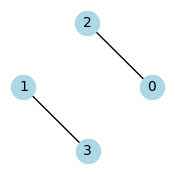

In [459]:
list_of_slices[0].show()
list_of_slices[0].quantum_circuit.draw()

In [460]:
def circuit_from_slices(slices:list[TimeSlice], num_qubits):
    '''Given a list of TimeSlices and the number of qubits of the
    final circuit, it returns the circuit with barriers separating
    different time slices'''
    qc = QuantumCircuit(num_qubits)
    for slice in slices:
        qc.compose(slice.quantum_circuit, inplace=True)
        qc.barrier()
    return qc

qc2_sliced = circuit_from_slices(list_of_slices, 5)
qc2_sliced.draw()


░       ░       ░            ░            ░ 
q_0: ──■────────░───■───░───────░───■────────░────────────░─
       │        ░ ┌─┴─┐ ░       ░   │        ░            ░ 
q_1: ──┼────■───░─┤ X ├─░───■───░───┼────■───░───■────────░─
     ┌─┴─┐  │   ░ └───┘ ░   │   ░   │    │   ░   │        ░ 
q_2: ┤ X ├──┼───░───────░───┼───░───┼────┼───░───┼────■───░─
     └───┘┌─┴─┐ ░       ░ ┌─┴─┐ ░ ┌─┴─┐  │   ░ ┌─┴─┐  │   ░ 
q_3: ─────┤ X ├─░───■───░─┤ X ├─░─┤ X ├──┼───░─┤ X ├──┼───░─
          └───┘ ░ ┌─┴─┐ ░ └───┘ ░ └───┘┌─┴─┐ ░ └───┘┌─┴─┐ ░ 
q_4: ───────────░─┤ X ├─░───────░──────┤ X ├─░──────┤ X ├─░─
                ░ └───┘ ░       ░      └───┘ ░      └───┘ ░

In [461]:
def draw_graphs(list_of_edges):
    '''Function to plot a graph of connected nodes'''
    # Calcola il numero di sottofigure necessarie
    num_subfigures = len(list_of_edges)
    
    # Crea una figura con un numero di sottofigure adeguato
    fig, axs = plt.subplots(1, num_subfigures, figsize=(2.5 * num_subfigures, 2.5))
    
    # Se c'è solo una sottofigura, axs non è una lista, quindi lo rendiamo una lista
    if num_subfigures == 1:
        axs = [axs]
    
    for i, edges in enumerate(list_of_edges):
        # Crea un grafo non orientato
        G = nx.Graph()
        
        # Aggiungi gli archi al grafo
        G.add_edges_from(edges)
        
        # Disegna il grafo nella sottofigura corrispondente
        pos = nx.shell_layout(G, scale=0.4, rotate=0)  # Posizioni dei nodi
        nx.draw(G, pos, ax=axs[i], with_labels=True, node_size=300, node_color='lightblue', font_size=10, font_color='black')
        
        # Imposta il titolo della sottofigura
        axs[i].set_title(f'Graph {i}')
    
    # Mostra la figura
    plt.tight_layout()
    plt.show()



In [462]:
# m = [2,3]
# vec2 = [boolean_var('x0'), boolean_var('x1')]
# m = np.asarray(m)
# print(m)

# my_mat = np.empty( shape=(2, 2), dtype = object)
# my_mat[0][0] = boolean_var('x00')
# my_mat[0][1] = boolean_var('x01')
# my_mat[1][0] = boolean_var('x10')
# my_mat[1][1] = boolean_var('x11')
# ## x00 x01
# ## x10 x11

# # my_mat[0][0] = 1
# # my_mat[0][1] = 2
# # my_mat[1][0] = 3
# # my_mat[1][1] = 4

# print(my_mat)
# print()
# prod1 = np.dot(my_mat, m)
# prod2 = np.dot(m, my_mat)
# print(prod1)
# print(prod2)

# print(np.dot(m, vec2))
# print(np.dot(vec2, m))
# # x[t][j][i] --> boolean_var di qubo
# # x[t][j]    --> vettore di boolean_var
# # t: slice
# # j: core
# # i: qubit


In [463]:
# a = np.empty( shape=(2, 2), dtype = object)
# a[0][0] = 2
# a[0][1] = -1
# a[1][0] = -3
# a[1][1] = 2

# b = [1, 2]
# # b = np.atleast_2d(b)
# w = [-2, 1]
# # w = np.atleast_2d(w).T
# print(a)
# print()
# print(b)
# print()
# print(w)
# print()
# ba = np.dot(b, a)
# print(ba)
# prod = np.dot(ba, w)
# print(prod)

In [464]:


# num_slices = 2
# num_cores = 2
# num_qubits = 3
# cores_capacity = [2,3]
# x = create_x(num_slices, num_cores, num_qubits)
# y = create_y(num_slices, num_cores, cores_capacity)
# print(x)
# print(y)

In [465]:
# Sxt = []
# for t, l2 in enumerate(x):
#     s_tot = QUBO()
#     for i in range(num_qubits):
#         s1 = QUBO()
#         for j in range(num_cores):
#             s1 += x[t][j][i]
#         s_tot += (s1 - 1)**2
#         # print((s1 - 1)**2)
#         # print("\n\n")
#     # print(s_tot)
#     # print("\n\n")
#     Sxt.append(s_tot)

In [466]:
# Rxt = []

# for t, l2 in enumerate(x):
#     s_tot = QUBO()
#     for j, l1 in enumerate(x[t]):
#         # print(f"j = {j}")
#         s1 = QUBO()
#         for i, _ in enumerate(x[t][j]):
#             # print(f"i = {i}")
#             s1 += x[t][j][i]
#         print(s1)
#         s2 = QUBO()
#         for i_prime in range(cores_capacity[j]):
#             # print(f"i_prime = {i_prime}")

#             s2 += y[t][j][i_prime]
#         s_12 = (s1 - s2)**2
#         s_tot += s_12 # s_tot = s_tot + s_12
#     Rxt.append(s_tot)
# print(Rxt[0])

In [467]:
# Pxt = []
# qctest = QuantumCircuit(num_qubits)
# qctest.cx(0,2)
# # qctest.cx(1,2)
# qctest.cx(0,1)
# # qctest.draw()
# slices = slice_circuit(qctest, 3)
# slices[0].show()
# for t, l2 in enumerate(x):
#     s_tot = QUBO()
#     for k in range(num_cores):
#         prod1 = np.dot(x[t][j], slices[t].laplacian)
#         s_tot += np.dot(prod1, x[t][j])
#     print(s_tot)
#     print()
#     Pxt.append(s_tot)

In [468]:
class MultiCoreMapper:
    def __init__(self, qc:QCtype, num_cores:int, cores_capacities:list[int]):
        self.num_cores = num_cores
        self.cores_capacities = cores_capacities
        self.qc = qc
        print(qc.num_qubits)
        self.num_qubits = qc.num_qubits
        self.slices = slice_circuit(qc, self.num_qubits)

        self.x = self.create_x()
        self.y = self.create_y()

    def create_x(self):
        '''Returns the X data structure of binary variables'''
        # [x0, x1, x2, x3, ...]
        x = []
        for t in range(len(self.slices)):
            l2 = []
            for j in range(self.num_cores):
                l1 = []
                for i in range(self.num_qubits):
                    bv = boolean_var(f"x_{t}_{j}_{i}")
                    l1.append(np.atleast_1d(bv))
                l2.append(np.asarray(l1))
            x.append(l2)
        return x
    
    def create_y(self):
        '''Returns the Y data structure of binary variables representing the auxialiry variables'''
        y = []
        for t in range(len(self.slices)):
            l2 = []
            for j in range(self.num_cores):
                l1 = []
                for i in range(self.cores_capacities[j]):
                    bv = boolean_var(f"y_{t}_{j}_{i}")
                    l1.append(bv)
                l2.append(np.asarray(l1))
            y.append(l2)
        return y


$$
R({\bf x}^{t}):=\sum_{j=1}^{k}\left(\sum_{i=1}^{n}x_{i j}^{t}-\sum_{i^{\prime}=1}^{c_{j}}y_{i^{\prime}j}^{t}\right)^{2}
$$

In [469]:
# I redefined the class just to be able to split the functions in different cells
class MultiCoreMapper(MultiCoreMapper):
    @property
    def Rxt(self):
        Rxt = []

        for t, l2 in enumerate(self.x):
            s_tot = QUBO()
            for j, l1 in enumerate(self.x[t]):
                # print(f"j = {j}")
                s1 = QUBO()
                for i, _ in enumerate(self.x[t][j]):
                    # print(f"i = {i}")
                    s1 += self.x[t][j][i]
                # print(s1)
                s2 = QUBO()
                for i_prime in range(self.cores_capacities[j]):
                    # print(f"i_prime = {i_prime}")

                    s2 += self.y[t][j][i_prime]
                s_12 = (s1 - s2)**2
                s_tot += s_12 # s_tot = s_tot + s_12
            Rxt.append(s_tot)
        return Rxt
   

$$
S({\bf x}^{t}):=\sum_{i=1}^{n}\left(\sum_{j=1}^{k}x_{i j}^{t}-1\right)^{2}
$$

In [ ]:
 
class MultiCoreMapper(MultiCoreMapper):
    @property
    def Sxt(self):
        Sxt = []
        for t, l2 in enumerate(self.x):
            s_tot = QUBO()
            for i in range(self.num_qubits):
                s1 = QUBO()
                for j in range(self.num_cores):
                    s1 += self.x[t][j][i]
                s_tot += (s1 - 1)**2
                # print((s1 - 1)**2)
                # print("\n\n")
            # print(s_tot)
            # print("\n\n")
            Sxt.append(s_tot)
        return Sxt


$$ P({\bf x}^{t}):=\sum_{j=1}^{k}{\bf x}_{j}^{t T}L_{t}{\bf x}_{j}^{t} $$

In [ ]:

class MultiCoreMapper(MultiCoreMapper):
    @property
    def Pxt(self):
        Pxt = []
        qctest = QuantumCircuit(self.num_qubits)
        qctest.cx(0,2)
        # qctest.cx(1,2)
        qctest.cx(0,1)
        # qctest.draw()
        for t, l2 in enumerate(self.x):
            s_tot = QUBO()
            for j in range(self.num_cores):
                prod1 = np.dot( self.x[t][j].T, self.slices[t].laplacian)
                s_tot += np.dot(prod1, self.x[t][j])
            # print(s_tot)
            # print()
            Pxt.append(s_tot)
        return Pxt

In [470]:
mcm = MultiCoreMapper(qc2, 2, [2,2])
# mcm.slices[0].show()
# v1 = mcm.x[0][0]
# mat = mcm.slices[0].laplacian

# print(v1.T)
# print(mat)
# print(v1)
# p1 = (np.dot(v1.T, mat))
# print(p1)
# print(np.dot(p1, v1))
# np.dot()
# # for i in mcm.x:
# #     for j in i:
# #         print(j)
# #     print()
for i in mcm.Pxt:
    print(len(i))
    print(i)
    print()

5
1
{(): array([[{('x_0_0_0',): 1, ('x_0_0_0', 'x_0_0_2'): -2, ('x_0_0_1',): 1, ('x_0_0_1', 'x_0_0_3'): -2, ('x_0_0_2',): 1, ('x_0_0_3',): 1, ('x_0_1_0',): 1, ('x_0_1_0', 'x_0_1_2'): -2, ('x_0_1_1',): 1, ('x_0_1_1', 'x_0_1_3'): -2, ('x_0_1_2',): 1, ('x_0_1_3',): 1}]],
      dtype=object)}

1
{(): array([[{('x_1_0_0',): 1, ('x_1_0_0', 'x_1_0_1'): -2, ('x_1_0_1',): 1, ('x_1_0_3',): 1, ('x_1_0_3', 'x_1_0_4'): -2, ('x_1_0_4',): 1, ('x_1_1_0',): 1, ('x_1_1_0', 'x_1_1_1'): -2, ('x_1_1_1',): 1, ('x_1_1_3',): 1, ('x_1_1_3', 'x_1_1_4'): -2, ('x_1_1_4',): 1}]],
      dtype=object)}

1
{(): array([[{('x_2_0_1',): 1, ('x_2_0_1', 'x_2_0_3'): -2, ('x_2_0_3',): 1, ('x_2_1_1',): 1, ('x_2_1_1', 'x_2_1_3'): -2, ('x_2_1_3',): 1}]],
      dtype=object)}

1
{(): array([[{('x_3_0_0',): 1, ('x_3_0_0', 'x_3_0_3'): -2, ('x_3_0_1',): 1, ('x_3_0_1', 'x_3_0_4'): -2, ('x_3_0_3',): 1, ('x_3_0_4',): 1, ('x_3_1_0',): 1, ('x_3_1_0', 'x_3_1_3'): -2, ('x_3_1_1',): 1, ('x_3_1_1', 'x_3_1_4'): -2, ('x_3_1_3',): 1, ('x_3_1_